## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [143]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint
from sklearn.model_selection import train_test_split

import collections, re, string

from matplotlib import rcParams
import matplotlib.cm as cm

from wordcloud import WordCloud, STOPWORDS

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.util import ngrams

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

import swifter
import tqdm
import random

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\joshu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\joshu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\joshu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\joshu\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [9]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json') # Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [10]:
# Inspect the dataframe to understand the given data.

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [11]:
#print the column names
list(df.columns)

['_index',
 '_type',
 '_id',
 '_score',
 '_source.tags',
 '_source.zip_code',
 '_source.complaint_id',
 '_source.issue',
 '_source.date_received',
 '_source.state',
 '_source.consumer_disputed',
 '_source.product',
 '_source.company_response',
 '_source.company',
 '_source.submitted_via',
 '_source.date_sent_to_company',
 '_source.company_public_response',
 '_source.sub_product',
 '_source.timely',
 '_source.complaint_what_happened',
 '_source.sub_issue',
 '_source.consumer_consent_provided']

In [12]:
#Assign new column names
df.columns = df.columns.str.removeprefix('_source.')
df.columns = df.columns.str.removeprefix('_')

In [13]:
#Assign nan in place of blanks in the complaints column
df['complaints'] = df['complaint_what_happened'].replace(r'^\s*$', np.nan, regex = True)
df.drop(columns = ['complaint_what_happened'], inplace = True)

In [15]:
#Remove all rows where complaints column is nan
df = df.dropna(subset = ['complaints'])

In [16]:
df.shape

(21072, 22)

In [17]:
df.complaints.head()

1     Good morning my name is XXXX XXXX and I apprec...
2     I upgraded my XXXX XXXX card in XX/XX/2018 and...
10    Chase Card was reported on XX/XX/2019. However...
11    On XX/XX/2018, while trying to book a XXXX  XX...
14    my grand son give me check for {$1600.00} i de...
Name: complaints, dtype: object

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [31]:
# Write your function here to clean the text and remove all the unnecessary elements.

def clean_corpus(text):
    text = text.lower()
    text = re.sub('\[.*?\]\s*', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub('\w*\d+\w*\s*', '', text)
    return text

In [21]:
#Write your function to Lemmatize the texts
lemmatizer = WordNetLemmatizer()
def apply_lemma(text):
    tokens = word_tokenize(text)
    lemma_tokens = []
    for token, tag in pos_tag(tokens):
        lemma_word = lemmatizer.lemmatize(token, get_pos(tag))
        lemma_tokens.append(lemma_word)
    return ' '.join(lemma_tokens)

def get_pos(word):
    if word.startswith('J'):
        return wordnet.ADJ
    elif word.startswith('V'):
        return wordnet.VERB
    elif word.startswith('N'):
        return wordnet.NOUN
    elif word.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN   

In [34]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame()
df_clean['complaints'] = df.complaints.swifter.apply(clean_corpus)
df_clean['lemmatized_complaints'] = df_clean.complaints.swifter.apply(apply_lemma)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [35]:
df_clean

,complaints,lemmatized_complaints
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told b...,i upgrade my xxxx xxxx card in and be tell by ...
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...
11,on while trying to book a xxxx xxxx ticket i...,on while try to book a xxxx xxxx ticket i come...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas my xxxx xxxx...
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs ive had cha...,i have have flawless credit for yrs ive have c...


In [37]:
#Write your function to extract the POS tags 
model = spacy.load('en_core_web_sm')
def pos_tag(text):
  # write your code here
    nouns = []
    docu = model(text)
    for token in docu:
        if token.pos_ in ['NOUN', 'PROPN']:
            nouns.append(token.text)
    return ' '.join(nouns)

df_clean["complaint_POS_removed"] = df_clean.complaints.swifter.apply(pos_tag) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [40]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...,morning name xxxx stop bank cardmember service...
2,i upgraded my xxxx xxxx card in and was told b...,i upgrade my xxxx xxxx card in and be tell by ...,xxxx card agent upgrade anniversary date agent...
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase card application identity consent servic...
11,on while trying to book a xxxx xxxx ticket i...,on while try to book a xxxx xxxx ticket i come...,xxxx xxxx ticket offer ticket rewards card inf...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitations credit card...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas my xxxx xxxx...,wednesday xxxxxxxx chas xxxx visa credit card ...
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...,xxxx risk consumers chase bank app chase years...
78311,i have had flawless credit for yrs ive had cha...,i have have flawless credit for yrs ive have c...,credit yrs credit cards chase freedom xxxx pro...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




<AxesSubplot:title={'center':'length on complaints distribution'}, xlabel='Complaint length', ylabel='Frequency'>

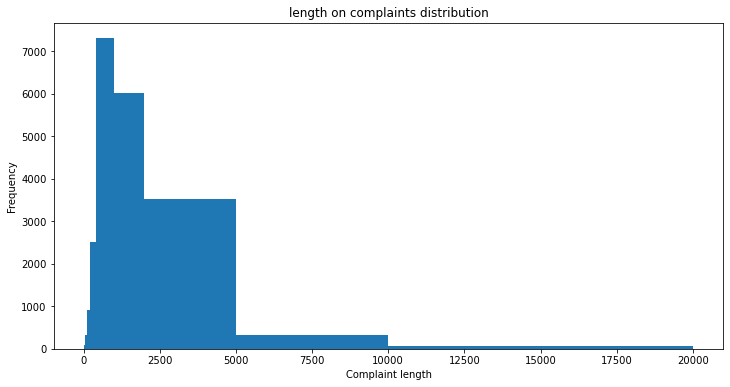

In [41]:
# Write your code here to visualise the data according to the 'Complaint' character length

plt.xlabel('Complaint length')
plt.ylabel('frequency')
plt.title('length on complaints distribution')

df_clean['complaints'].str.len().plot(kind = 'hist', bins = [20,50,100,200,400,1000,2000,5000,10000,20000],
                                                     figsize = (12,6))

#### Find the top 40 words by frequency among all the articles after processing the text.

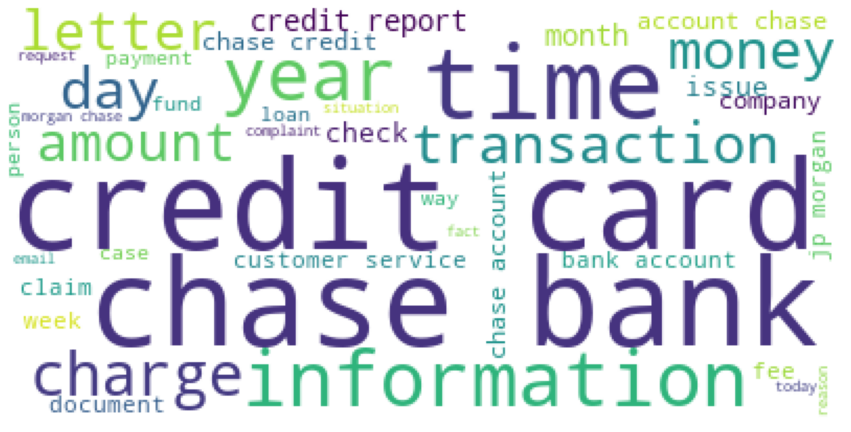

{'credit card': 1.0,
 'chase bank': 0.9513429349941611,
 'time': 0.6444530945893344,
 'information': 0.42701440249124173,
 'year': 0.3983651226158038,
 'charge': 0.3848968470221876,
 'day': 0.3371739976644609,
 'money': 0.3338263915920592,
 'transaction': 0.3300116776956014,
 'amount': 0.30829116387699496,
 'letter': 0.3050214091086026,
 'credit report': 0.30073958738808876,
 'month': 0.29887115609186454,
 'check': 0.2766056831451927,
 'issue': 0.27629427792915534,
 'account chase': 0.2695990657843519,
 'chase account': 0.2659400544959128,
 'company': 0.25254963020630594,
 'chase credit': 0.24850136239782017,
 'customer service': 0.23900350330868042,
 'bank account': 0.217516543402102,
 'document': 0.21595951732191515,
 'jp morgan': 0.21416893732970027,
 'fee': 0.21004281821720514,
 'claim': 0.20833008952899962,
 'week': 0.20747372518489685,
 'payment': 0.20544959128065396,
 'fund': 0.2035033086804204,
 'loan': 0.19400544959128066,
 'way': 0.19392759828727132,
 'person': 0.193538341767

In [47]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
all_complaints = ' '.join(df_clean['complaint_POS_removed'])
all_complaints = re.sub('x{2,}', 'x', all_complaints)

stopwords = STOPWORDS
stopwords.add('x')
wordcloud = WordCloud(stopwords = stopwords, background_color = 'white', max_words = 40).generate(all_complaints)

rcParams['figure.figsize'] = 15, 15
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

wordcloud.words_

<BarContainer object of 40 artists>

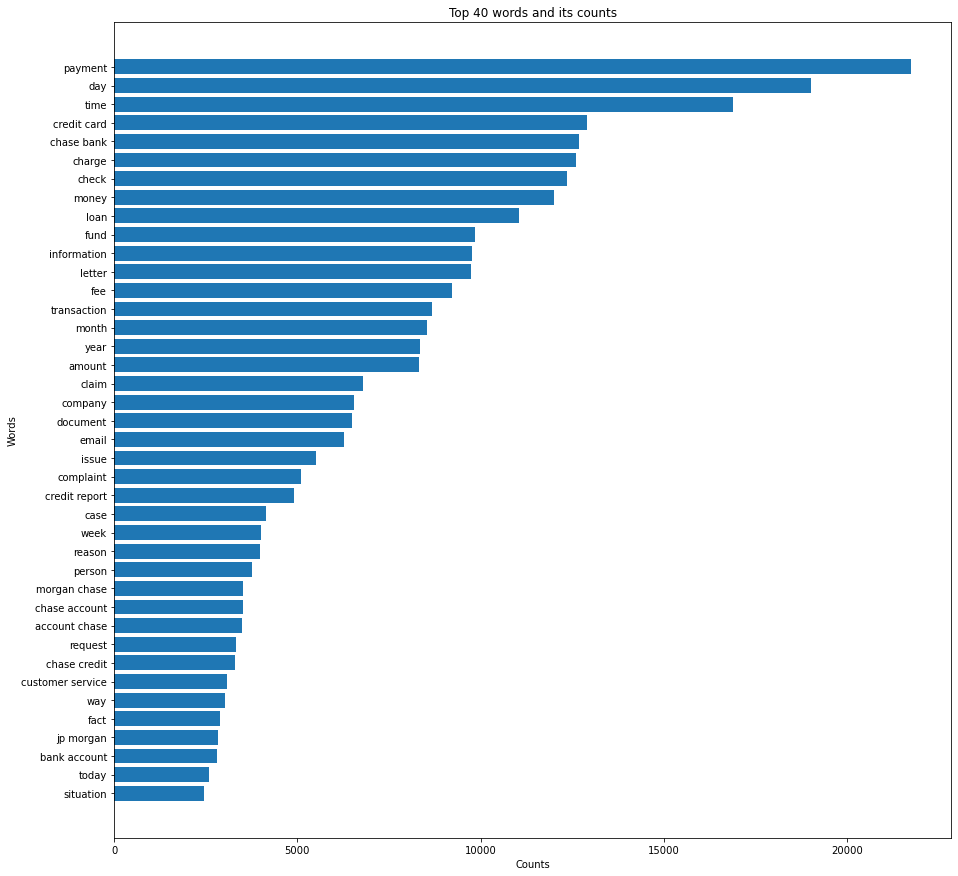

In [55]:
words = []
counts = []

for word in wordcloud.words_:
    words.append(word)
    counts.append(all_complaints.count(word))
    
word_counts = pd.DataFrame({'words':  words, 'counts': counts})
word_counts = word_counts.sort_values(by = ['counts'])

rcParams['figure.figsize'] = 15,15
plt.xlabel('Counts')
plt.ylabel('Words')
plt.title('Top 40 words and its counts')
plt.barh(word_counts['words'], word_counts['counts'])

In [56]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [59]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
all_complaints = all_complaints.replace('x', '')
tokenize = all_complaints.split()
unigrams = ngrams(tokenize, 1)
unigrams_frequency = collections.Counter(unigrams)

for word in unigrams_frequency.most_common(30):
    print(f'{word[0][0]} : {word[1]}')

chase : 72813
account : 41453
credit : 32238
card : 26743
bank : 26445
payment : 13965
time : 11967
money : 11942
loan : 9971
information : 9643
letter : 8415
check : 8258
mortgage : 7922
number : 7752
amount : 7579
phone : 7487
days : 7465
payments : 7202
balance : 7150
fraud : 6867
funds : 6704
company : 6491
charges : 6444
customer : 6438
report : 5978
accounts : 5661
charge : 5635
day : 5516
business : 5457
service : 5373


In [60]:
#Print the top 10 words in the unigram frequency
for word in unigrams_frequency.most_common(10):
    print(f'{word[0][0]} : {word[1]}')

chase : 72813
account : 41453
credit : 32238
card : 26743
bank : 26445
payment : 13965
time : 11967
money : 11942
loan : 9971
information : 9643


In [71]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
bigram = ngrams(tokenize, 2)
bigram_frequency = collections.Counter(bigram)

for word in bigram_frequency.most_common(30):
    print(f'{word[0]} : {word[1]}')

('chase', 'bank') : 12141
('credit', 'card') : 10969
('account', 'chase') : 3903
('chase', 'credit') : 3453
('credit', 'report') : 3245
('chase', 'account') : 3211
('customer', 'service') : 3026
('jp', 'morgan') : 2756
('bank', 'account') : 2586
('morgan', 'chase') : 2459
('account', 'account') : 2123
('card', 'chase') : 1971
('credit', 'cards') : 1890
('debit', 'card') : 1856
('chase', 'card') : 1757
('chase', 'chase') : 1646
('credit', 'score') : 1591
('money', 'account') : 1348
('letter', 'chase') : 1339
('card', 'account') : 1318
('account', 'credit') : 1258
('bank', 'chase') : 1205
('chase', 'mortgage') : 1153
('phone', 'number') : 1135
('interest', 'rate') : 1070
('account', 'number') : 1060
('jpmorgan', 'chase') : 1049
('fraud', 'department') : 1028
('credit', 'reporting') : 1024
('business', 'days') : 1011


In [72]:
#Print the top 10 words in the bigram frequency
for word in bigram_frequency.most_common(10):
    print(f'{word[0]} : {word[1]}')

('chase', 'bank') : 12141
('credit', 'card') : 10969
('account', 'chase') : 3903
('chase', 'credit') : 3453
('credit', 'report') : 3245
('chase', 'account') : 3211
('customer', 'service') : 3026
('jp', 'morgan') : 2756
('bank', 'account') : 2586
('morgan', 'chase') : 2459


In [69]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
trigrams = ngrams(tokenize, 3)
trigrams_frequency = collections.Counter(trigrams)

for word in trigrams_frequency.most_common(30):
    print(f'{word[0]} : {word[1]}')

('jp', 'morgan', 'chase') : 2299
('chase', 'credit', 'card') : 1979
('credit', 'card', 'chase') : 878
('account', 'chase', 'bank') : 877
('chase', 'bank', 'account') : 870
('credit', 'card', 'company') : 797
('credit', 'card', 'account') : 767
('morgan', 'chase', 'bank') : 678
('chase', 'customer', 'service') : 558
('chase', 'bank', 'credit') : 508
('chase', 'bank', 'chase') : 443
('credit', 'card', 'credit') : 422
('card', 'chase', 'bank') : 383
('jpmorgan', 'chase', 'bank') : 376
('bank', 'chase', 'bank') : 353
('credit', 'reporting', 'act') : 346
('bank', 'credit', 'card') : 338
('chase', 'credit', 'cards') : 333
('card', 'credit', 'card') : 325
('credit', 'report', 'credit') : 320
('account', 'credit', 'card') : 315
('account', 'chase', 'account') : 308
('inquiry', 'credit', 'report') : 307
('credit', 'report', 'chase') : 303
('chase', 'account', 'chase') : 293
('credit', 'reporting', 'agencies') : 290
('chase', 'card', 'services') : 277
('customer', 'service', 'representative') : 

In [73]:
#Print the top 10 words in the trigram frequency
for word in trigrams_frequency.most_common(10):
    print(f'{word[0]} : {word[1]}')

('jp', 'morgan', 'chase') : 2299
('chase', 'credit', 'card') : 1979
('credit', 'card', 'chase') : 878
('account', 'chase', 'bank') : 877
('chase', 'bank', 'account') : 870
('credit', 'card', 'company') : 797
('credit', 'card', 'account') : 767
('morgan', 'chase', 'bank') : 678
('chase', 'customer', 'service') : 558
('chase', 'bank', 'credit') : 508


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [74]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')
df_clean['lemmatized_complaints'] = df_clean['lemmatized_complaints'].str.replace('xxxx', '')
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].str.replace('xxxx', '')

In [75]:
#All masked texts has been removed
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be and i appreciate it ...,morning name stop bank cardmember services de...,morning name stop bank cardmember services de...
2,i upgraded my xxxx xxxx card in and was told b...,i upgrade my card in and be tell by the agen...,card agent upgrade anniversary date agent inf...,card agent upgrade anniversary date agent inf...
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase card application identity consent servic...,chase card application identity consent servic...
11,on while trying to book a xxxx xxxx ticket i...,on while try to book a ticket i come across ...,ticket offer ticket rewards card information...,ticket offer ticket rewards card information...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitations credit card...,card customer decade solicitations credit card...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday i call chas my visa credit car...,wednesday chas visa credit card provider cla...,wednesday chas visa credit card provider cla...
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with pay and do not underst...,risk consumers chase bank app chase years ban...,risk consumers chase bank app chase years ban...
78311,i have had flawless credit for yrs ive had cha...,i have have flawless credit for yrs ive have c...,credit yrs credit cards chase freedom problem...,credit yrs credit cards chase freedom problem...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [77]:
#Write your code here to initialise the TfidfVectorizer 

tfidf = TfidfVectorizer(analyzer= 'word', stop_words= 'english', max_df = 0.95, min_df = 2)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [94]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])
tfidf_tokens = tfidf.get_feature_names()
random.sample(tfidf_tokens, 10)

['static',
 'appraisers',
 'sa',
 'auditing',
 'clearcut',
 'postpone',
 'tila',
 'mth',
 'hl',
 'pass']

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [81]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [105]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state= 40) #write your code here
x = nmf_model.fit_transform(dtm)
y = nmf_model.components_

In [106]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

8520

In [110]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics,15)), index = [f'Topic {i+1}' for i in range(num_topics)], columns = [f'Word {i+1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = y[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]
                 
topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,chase,check,money,funds,branch,deposit,accounts,business,number,days,checks,fraud,transaction
Topic 2,credit,report,inquiry,card,inquiries,score,cards,accounts,account,chase,debt,reporting,limit,information,bureaus
Topic 3,loan,mortgage,chase,home,modification,property,payments,foreclosure,years,bank,house,morgan,rate,letter,jp
Topic 4,card,chase,charges,charge,credit,dispute,fraud,merchant,transaction,company,fee,purchase,phone,service,number
Topic 5,payment,payments,balance,month,fees,fee,statement,date,auto,time,chase,account,days,months,day


In [113]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
x_df = pd.DataFrame(x, columns=[num for num in range(num_topics)])
x_df['Topic'] = x_df.apply(lambda x : x.idxmax(), axis = 1)
x_df.head()

,0,1,2,3,4,Topic
0,0.023350,0.015875,0.015110,0.002558,0.008956,0
1,0.007023,0.001513,0.000763,0.019258,0.003660,3
2,0.000000,0.038906,0.001964,0.028088,0.000000,1
3,0.020583,0.055105,0.016365,0.024040,0.000000,1
4,0.072881,0.000000,0.006179,0.004733,0.000000,0


In [114]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean.reset_index(inplace=True)
df_clean['Topic'] = x_df['Topic'] #write your code to assign topics to each rows.

In [115]:
df_clean.head()

,index,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
0,1,good morning my name is xxxx xxxx and i apprec...,good morning my name be and i appreciate it ...,morning name stop bank cardmember services de...,morning name stop bank cardmember services de...,0
1,2,i upgraded my xxxx xxxx card in and was told b...,i upgrade my card in and be tell by the agen...,card agent upgrade anniversary date agent inf...,card agent upgrade anniversary date agent inf...,3
2,10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase card application identity consent servic...,chase card application identity consent servic...,1
3,11,on while trying to book a xxxx xxxx ticket i...,on while try to book a ticket i come across ...,ticket offer ticket rewards card information...,ticket offer ticket rewards card information...,1
4,14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,0


In [116]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,index,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
0,1,good morning my name is xxxx xxxx and i apprec...,good morning my name be and i appreciate it ...,morning name stop bank cardmember services de...,morning name stop bank cardmember services de...,0
10,24,mishandling of this account by chase auto and ...,mishandling of this account by chase auto and,account chase auto,account chase auto,0
6,17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,notice jp morgan chase account debit card tues...,notice jp morgan chase account debit card tues...,0
4,14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,0
12,27,i opened an account with chase bank on xxxx an...,i open an account with chase bank on and use ...,account chase bank code bonus terms account...,account chase bank code bonus terms account...,0
5,15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
2,10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase card application identity consent servic...,chase card application identity consent servic...,1
9,23,i have a chase credit card which is incorrectl...,i have a chase credit card which be incorrectl...,credit card data credit report company issue,credit card data credit report company issue,1
11,26,i have reached out to xxxx several times in at...,i have reach out to several time in attempt t...,times attempt inquiry creditor inquiry report...,times attempt inquiry creditor inquiry report...,1
3,11,on while trying to book a xxxx xxxx ticket i...,on while try to book a ticket i come across ...,ticket offer ticket rewards card information...,ticket offer ticket rewards card information...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [117]:
#Create the dictionary of Topic names and Topics

Topic_names = {0: 'Bank Account Services', 1:'Credit card or Prepaid card',
              2: 'Theft/Dispute Reporting', 3: 'Mortgage/Loan', 4: 'Others'}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

C:\Users\joshu\AppData\Local\Temp\ipykernel_12780\1434294620.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [118]:
df_clean

,index,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
0,1,good morning my name is xxxx xxxx and i apprec...,good morning my name be and i appreciate it ...,morning name stop bank cardmember services de...,morning name stop bank cardmember services de...,Bank Account Services
1,2,i upgraded my xxxx xxxx card in and was told b...,i upgrade my card in and be tell by the agen...,card agent upgrade anniversary date agent inf...,card agent upgrade anniversary date agent inf...,Mortgage/Loan
2,10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase card application identity consent servic...,chase card application identity consent servic...,Credit card or Prepaid card
3,11,on while trying to book a xxxx xxxx ticket i...,on while try to book a ticket i come across ...,ticket offer ticket rewards card information...,ticket offer ticket rewards card information...,Credit card or Prepaid card
4,14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,Bank Account Services
5,15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,Credit card or Prepaid card
6,17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,notice jp morgan chase account debit card tues...,notice jp morgan chase account debit card tues...,Bank Account Services
7,20,during the summer months i experience a declin...,during the summer month i experience a decline...,summer months decline income employment month ...,summer months decline income employment month ...,Others
8,21,on xxxx i made a payment to an online retailer...,on i make a payment to an online retailer use...,payment retailer chase pay chase website sca...,payment retailer chase pay chase website sca...,Mortgage/Loan
9,23,i have a chase credit card which is incorrectl...,i have a chase credit card which be incorrectl...,credit card data credit report company issue,credit card data credit report company issue,Credit card or Prepaid card


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [119]:
#Create the dictionary again of Topic names and Topics

Topic_names = {'Bank Account Services': 0, 'Credit card or Prepaid card': 1,
              'Theft/Dispute Reporting':2, 'Mortgage/Loan':3, 'Others':4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

C:\Users\joshu\AppData\Local\Temp\ipykernel_12780\3728401913.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [120]:
df_clean

,index,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
0,1,good morning my name is xxxx xxxx and i apprec...,good morning my name be and i appreciate it ...,morning name stop bank cardmember services de...,morning name stop bank cardmember services de...,0
1,2,i upgraded my xxxx xxxx card in and was told b...,i upgrade my card in and be tell by the agen...,card agent upgrade anniversary date agent inf...,card agent upgrade anniversary date agent inf...,3
2,10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase card application identity consent servic...,chase card application identity consent servic...,1
3,11,on while trying to book a xxxx xxxx ticket i...,on while try to book a ticket i come across ...,ticket offer ticket rewards card information...,ticket offer ticket rewards card information...,1
4,14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,0
5,15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
6,17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,notice jp morgan chase account debit card tues...,notice jp morgan chase account debit card tues...,0
7,20,during the summer months i experience a declin...,during the summer month i experience a decline...,summer months decline income employment month ...,summer months decline income employment month ...,4
8,21,on xxxx i made a payment to an online retailer...,on i make a payment to an online retailer use...,payment retailer chase pay chase website sca...,payment retailer chase pay chase website sca...,3
9,23,i have a chase credit card which is incorrectl...,i have a chase credit card which be incorrectl...,credit card data credit report company issue,credit card data credit report company issue,1


In [123]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[['complaints', 'Topic']].copy()

In [124]:
training_data

,complaints,Topic
0,good morning my name is xxxx xxxx and i apprec...,0
1,i upgraded my xxxx xxxx card in and was told b...,3
2,chase card was reported on however fraudulent ...,1
3,on while trying to book a xxxx xxxx ticket i...,1
4,my grand son give me check for i deposit it in...,0
5,can you please remove inquiry,1
6,with out notice jp morgan chase restricted my ...,0
7,during the summer months i experience a declin...,4
8,on xxxx i made a payment to an online retailer...,3
9,i have a chase credit card which is incorrectl...,1


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [126]:

#Write your code to get the Vector count
count_vectorizer = CountVectorizer(analyzer= 'word', stop_words= 'english')
count_vector = count_vectorizer.fit_transform(training_data['complaints'])
count_vector_features = count_vectorizer.get_feature_names()

#Write your code here to transform the word vector to tf-idf
transformer = TfidfTransformer(smooth_idf = False)
tfidf_final = transformer.fit_transform(count_vector)
transformer.idf_

array([4.21887582, 4.21887582, 4.21887582, 4.21887582, 4.21887582,
       1.73396918, 4.21887582, 4.21887582, 3.52572864, 4.21887582,
       4.21887582, 4.21887582, 4.21887582, 4.21887582, 3.12026354,
       4.21887582, 4.21887582, 4.21887582, 3.52572864, 4.21887582,
       4.21887582, 4.21887582, 3.52572864, 4.21887582, 4.21887582,
       3.52572864, 4.21887582, 3.52572864, 4.21887582, 4.21887582,
       4.21887582, 4.21887582, 4.21887582, 4.21887582, 3.52572864,
       4.21887582, 4.21887582, 3.52572864, 2.83258146, 3.52572864,
       4.21887582, 3.52572864, 2.60943791, 3.12026354, 4.21887582,
       4.21887582, 3.52572864, 4.21887582, 4.21887582, 4.21887582,
       3.52572864, 4.21887582, 4.21887582, 4.21887582, 3.12026354,
       4.21887582, 4.21887582, 4.21887582, 2.83258146, 4.21887582,
       3.12026354, 4.21887582, 4.21887582, 4.21887582, 4.21887582,
       4.21887582, 4.21887582, 3.12026354, 1.73396918, 4.21887582,
       4.21887582, 4.21887582, 4.21887582, 4.21887582, 4.21887

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [128]:
# Write your code here to build any 3 models and evaluate them using the required metrics

X = tfidf_final
Y = training_data.Topic.values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 40)

### Logistic Regression Model

In [131]:
lr = LogisticRegression(solver= 'saga', class_weight= 'balanced', multi_class= 'multinomial')
lr.fit(X_train, y_train)

D:\ANACONDA\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   solver='saga')

In [151]:
y_pred_lr = lr.predict(X_test)

In [152]:
clf_report_lr = classification_report(y_test, y_pred_lr)
print(clf_report_lr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           2       1.00      1.00      1.00         1
           3       0.00      0.00      0.00         3
           4       1.00      1.00      1.00         1

    accuracy                           0.40         5
   macro avg       0.50      0.50      0.50         5
weighted avg       0.40      0.40      0.40         5



D:\ANACONDA\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

D:\ANACONDA\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

D:\ANACONDA\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

D:\ANACONDA\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

D:\ANACONDA\lib\site

In [154]:
lr_acc = accuracy_score(y_test, y_pred_lr)
lr_acc

0.4

### Decision Tree Model

In [139]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [148]:
y_pred_dt = dt.predict(X_test)

In [149]:
clf_report_dt = classification_report(y_test, y_pred_dt)
print(clf_report_dt)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.50      1.00      0.67         1
           3       0.00      0.00      0.00         3
           4       1.00      1.00      1.00         1

    accuracy                           0.40         5
   macro avg       0.30      0.40      0.33         5
weighted avg       0.30      0.40      0.33         5



D:\ANACONDA\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

D:\ANACONDA\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

D:\ANACONDA\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

D:\ANACONDA\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

D:\ANACONDA\lib\site

In [142]:
dt_acc = accuracy_score(y_test, y_pred)
dt_acc

0.4

### Random Forest Model

In [144]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

In [145]:
y_pred_rf = rf.predict(X_test)

In [146]:
clf_report_rf = classification_report(y_test, y_pred_rf)
print(clf_report_rf)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       1.0
           3       0.00      0.00      0.00       3.0
           4       0.00      0.00      0.00       1.0

    accuracy                           0.00       5.0
   macro avg       0.00      0.00      0.00       5.0
weighted avg       0.00      0.00      0.00       5.0



D:\ANACONDA\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

D:\ANACONDA\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

D:\ANACONDA\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

D:\ANACONDA\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

D:\ANACONDA\lib\site

In [147]:
rf_acc = accuracy_score(y_test, y_pred_rf)
rf_acc

0.0

#### Logistic Regression Model is best performing